In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import distance
import re
from bs4 import BeautifulSoup
import seaborn as sns
import string
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
print(dir(distance))

['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_fastcomp', '_iterators', '_lcsubstrings', '_levenshtein', '_pyimports', '_simpledists', 'array', 'fast_comp', 'hamming', 'ifast_comp', 'ilevenshtein', 'iquick_levenshtein', 'jaccard', 'lcsubstrings', 'levenshtein', 'nlevenshtein', 'quick_levenshtein', 'sorensen']


In [75]:
df=pd.read_csv('train.csv')

In [76]:
df.head(10)
#df.info()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [77]:
df.describe(include='all')

,id,qid1,qid2,question1,question2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404289,404288,404290.000000
unique,NaN,NaN,NaN,290456,299174,NaN
top,NaN,NaN,NaN,How do I improve my English speaking?,How can you look at someone's private Instagra...,NaN
freq,NaN,NaN,NaN,50,120,NaN
mean,202144.500000,217243.942418,220955.655337,NaN,NaN,0.369198
std,116708.614502,157751.700002,159903.182629,NaN,NaN,0.482588
min,0.000000,1.000000,2.000000,NaN,NaN,0.000000
25%,101072.250000,74437.500000,74727.000000,NaN,NaN,0.000000
50%,202144.500000,192182.000000,197052.000000,NaN,NaN,0.000000
75%,303216.750000,346573.500000,354692.500000,NaN,NaN,1.000000


In [78]:
#print(' Total points :{} \n Points in class 1 : {} {}'.format(df.shape[0],df['is_duplicate'].value_counts(),(df['is_duplicate'].value_counts()/df.shape[0])*100))
print((df['is_duplicate'].value_counts()/df.shape[0])*100)


0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


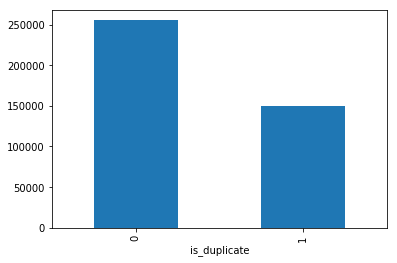

In [79]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [80]:
#number of Unique questions

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
repeated = np.sum(qids.value_counts() > 1)
max_repeated=max(qids.value_counts())

In [81]:
print('Number of Unique questions {} \nNo of repeated questions: {} \nMax repeated:{}'.format(unique_qs,repeated,max_repeated))

Number of Unique questions 537933 
No of repeated questions: 111780 
Max repeated:157


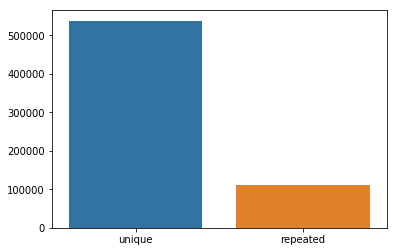

In [82]:
sns.barplot(y=[unique_qs,repeated],x=['unique','repeated'])

In [83]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions {} - {} = {}".format((pair_duplicates).shape[0],df.shape[0],(pair_duplicates).shape[0] - df.shape[0]))

Number of duplicate questions 404290 - 404290 = 0


In [84]:
#checking for nan values
df=df.fillna('')
df.isnull().any()

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

BASIC NLP FEATURE EXTRACTION BEFORE FEATURE EXTRACTION

In [118]:
def basic_feature_extraction():
    
    
    #1 freq of qid's
    df['freq1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq2']=df.groupby('qid2')['qid2'].transform('count')
    #Len of qid's
    df['len1']=len(df['question1'])
    df['len2']=len(df['question2'])
    #numwords
    df['numw1']=df['question1'].apply(lambda row: len(row.split(" ") ))
    df['numw2']=df['question2'].apply(lambda row: len(row.split(" ")))
    #commonwords
    def ge(row,idx):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        if(idx==1):return 1*len(w1&w2)  #Comonwords
        if(idx==2):return 1*len(w1)+len(w2)  #totlwords
        if(idx==3):return 1*(len(w1&w2)/len(w1)+len(w2)) #wordshare
    df['commonwords']=df.apply(ge,axis=1,idx=1)
    df['totalwords']=df.apply(ge,axis=1,idx=2)
    df['shareword']=df.apply(ge,axis=1,idx=3)
    df['total_freq']=df['freq1']+df['freq2']
    df['difference_freq']=abs(df['freq1']-df['freq2'])
    
    df.to_csv('df_1.csv',index=False)
        

In [119]:
basic_feature_extraction()

FEATURE ANALYSIS


In [123]:
print('Minimum lenght questions q1= "{}" and  q2= "{}"'.format(min(df['numw1']),min(df['numw2'])))
min1,min2=df[df['numw1']==1].shape[0],df[df['numw2']==1].shape[0]
print('Number of questions with minimum len in q1= "{}" and q2= "{}"'.format(min1,min2))

Minimum lenght questions q1= "1" and  q2= "1"
Number of questions with minimum len in q1= "68" and q2= "25"


WORD SHARE

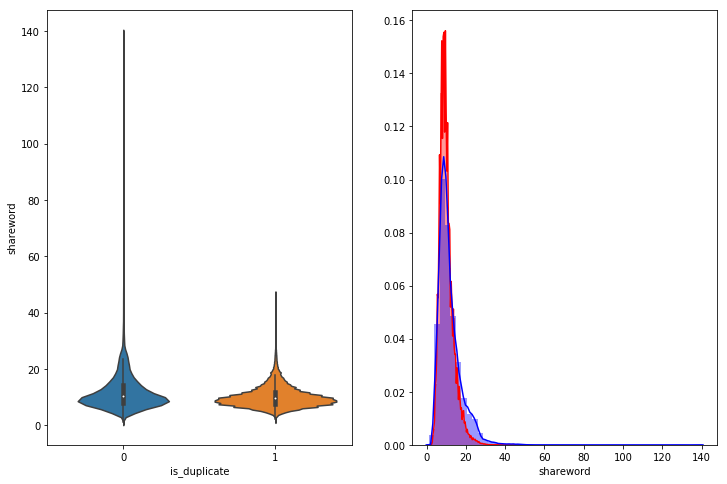

In [126]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'shareword', data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['shareword'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['shareword'][0:] , label = "0" , color = 'blue' )
plt.show()

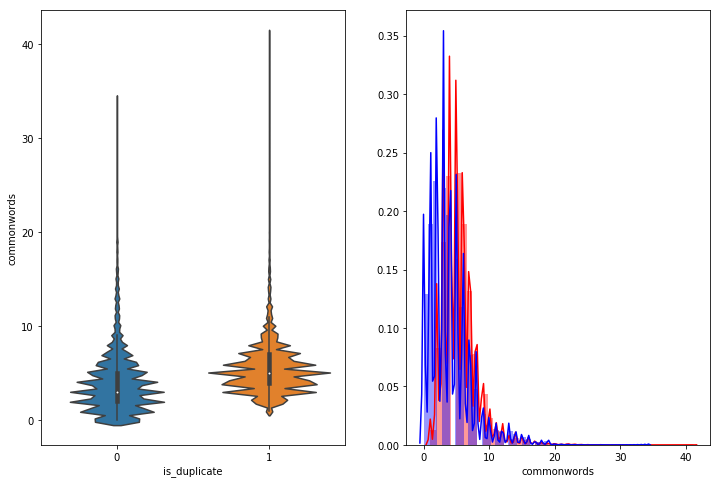

In [128]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'commonwords', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['commonwords'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['commonwords'][0:] , label = "0" , color = 'blue' )
plt.show()

In [5]:
#Performing NLP on text data
df1=pd.read_csv('df_1.csv')

In [6]:
df1.info()
df2=df1[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 19 columns):
id                 404290 non-null int64
qid1               404290 non-null int64
qid2               404290 non-null int64
question1          404289 non-null object
question2          404288 non-null object
is_duplicate       404290 non-null int64
freq1              404290 non-null int64
freq2              404290 non-null int64
len1               404290 non-null int64
len2               404290 non-null int64
numwrdsq1          404290 non-null int64
numwrdsq2          404290 non-null int64
commonwords        404290 non-null int64
totalwords         404290 non-null int64
shareword          404290 non-null float64
total_freq         404290 non-null int64
difference_freq    404290 non-null int64
numw1              404290 non-null int64
numw2              404290 non-null int64
dtypes: float64(1), int64(16), object(2)
memory usage: 58.6+ MB


In [7]:
stop=stopwords.words('english')
def text_preproc(x):
    stop=stopwords.words('english')
    x=x.lower()
    x=x.translate(str.maketrans('','',string.punctuation))
    e=BeautifulSoup(x)
    x=e.get_text()
    tokens = word_tokenize(x)
    result = [i for i in tokens if not i in stop]
    
    x=' '.join(xcw for xcw in result)
    stemmer= PorterStemmer()
    xc=[stemmer.stem(i) for i in word_tokenize(x)]
    x=' '.join(xcw for xcw in xc)
    return x
    
    
    

In [8]:
def tokenfeatures(q1,q2):
    SAFE_DIV = 0.0001
    token_features = [0.0]*10
    
    q1tokens=q1.split()
    q2tokens=q2.split()

    #words
    q1words=set([word for word in q1tokens if word not in stop])
    q2words=set([word for word in q2tokens if word not in stop])
    
    #stopwords
    q1stop=set([word for word in q1tokens if word in stop])
    q2stop=set([word for word in q2tokens if word in stop])
    
    #common word counts
    common_word_count=len(q1words.intersection(q2words))
    
    #common stop words
    common_stopword_count=len(q1stop.intersection(q2stop))
    
    #common token
    common_token_count=len(set(q1tokens).intersection(set(q2tokens)))
    token_features[0] = common_word_count / (min(len(q1words), len(q2words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1words), len(q2words)) + SAFE_DIV)
    token_features[2] = common_stopword_count / (min(len(q1stop), len(q2stop)) + SAFE_DIV)
    token_features[3] = common_stopword_count / (max(len(q1stop), len(q2stop)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1tokens), len(q2tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1tokens), len(q2tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1tokens[-1] == q2tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1tokens[0] == q2tokens[0])
    
    token_features[8] = abs(len(q1tokens) - len(q2tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1tokens) + len(q2tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

       
def extractfeatures(df):
       # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(text_preproc)
    df["question2"] = df["question2"].fillna("").apply(text_preproc)

    print("token features...")
    
    token_features=df.apply(lambda x:tokenfeatures(x['question1'],x['question2']),axis=1)
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
   
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df
df=extractfeatures(df1)
df.to_csv('nlp_features.csv',index=False)

    
    
    
    
    

In [4]:
df=pd.read_csv('nlp_features.csv',encoding='latin-1')

In [ ]:
Bivariate Analysis

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 21 columns):
id                      404290 non-null int64
qid1                    404290 non-null int64
qid2                    404290 non-null int64
question1               404276 non-null object
question2               404284 non-null object
is_duplicate            404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc_min                 404290 non-null float64
csc_max                 404290 non-null float64
ctc_min                 404290 non-null float64
ctc_max                 404290 non-null float64
last_word_eq            404290 non-null float64
first_word_eq           404290 non-null float64
abs_len_diff            404290 non-null float64
mean_len                404290 non-null float64
token_set_ratio         404290 non-null int64
token_sort_ratio        404290 non-null int64
fuzz_ratio              404290 non-null

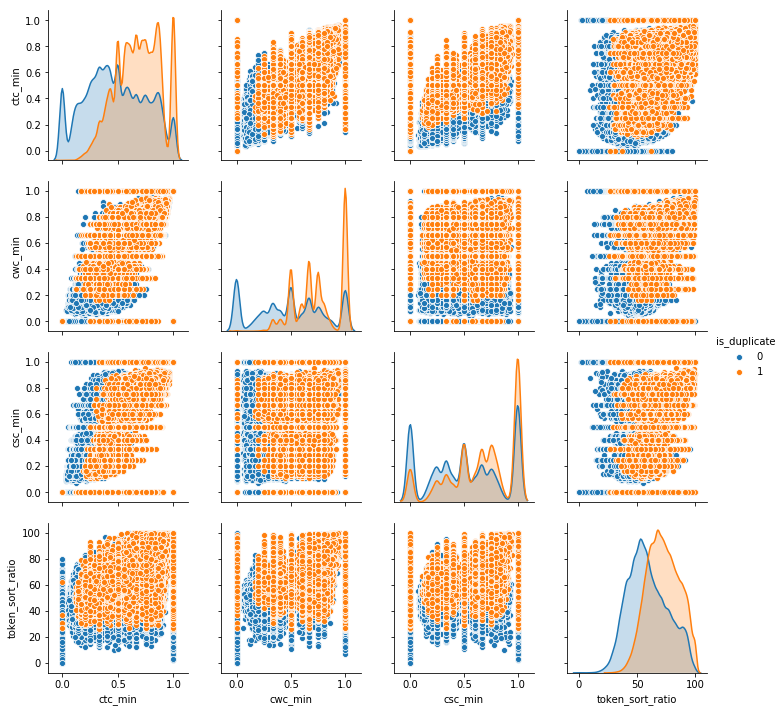

In [11]:
sns.pairplot(df[['ctc_min','cwc_min','csc_min','token_sort_ratio', 'is_duplicate']][0:df.shape[0]],hue='is_duplicate',vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

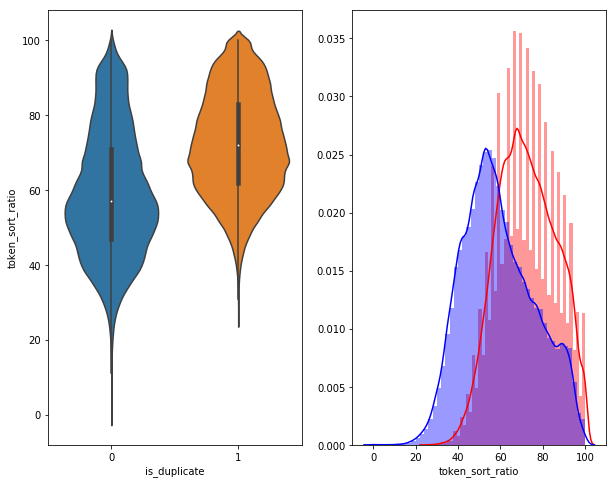

In [18]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()





       CWC_MIN     1


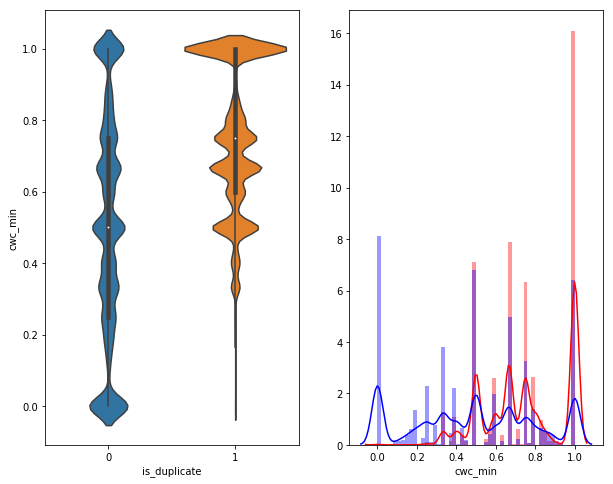





       CWC_MAX     2


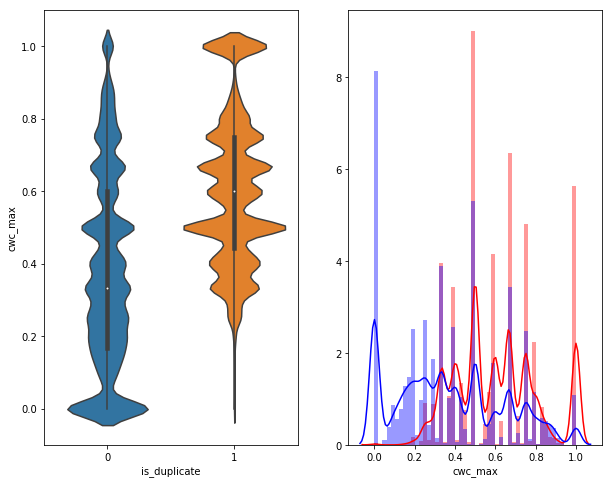





       CSC_MIN     3


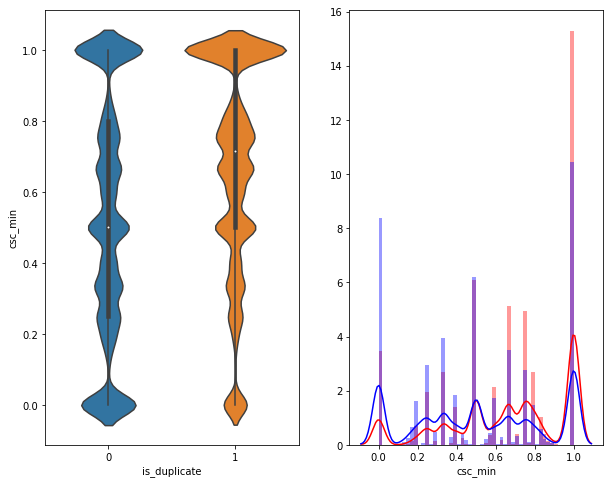





       CSC_MAX     4


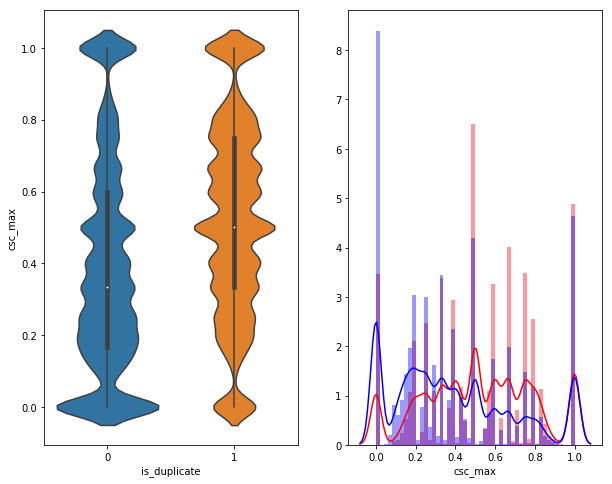





       CTC_MIN     5


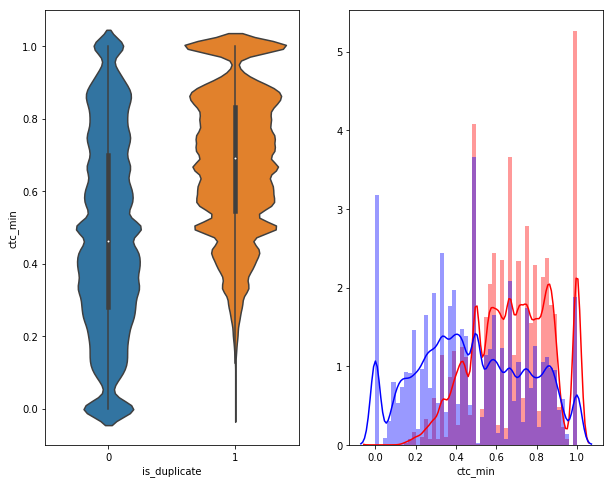





       CTC_MAX     6


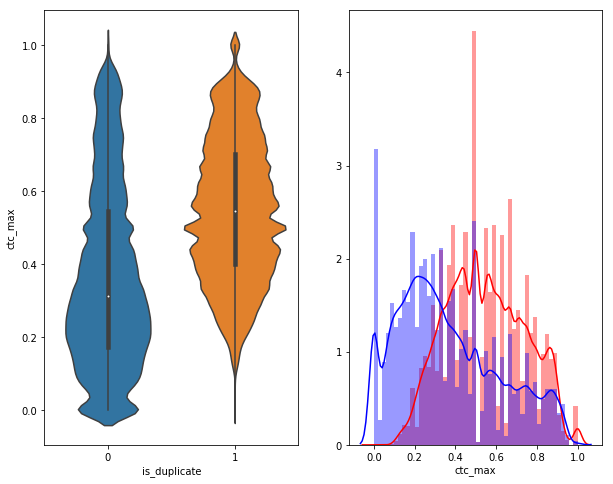





       LAST_WORD_EQ     7


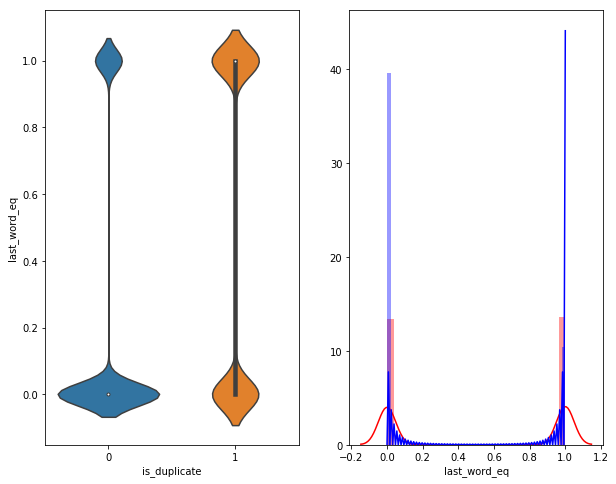





       FIRST_WORD_EQ     8


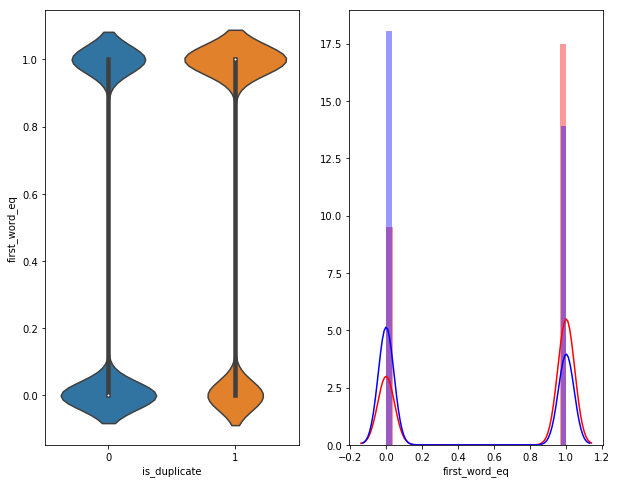





       ABS_LEN_DIFF     9


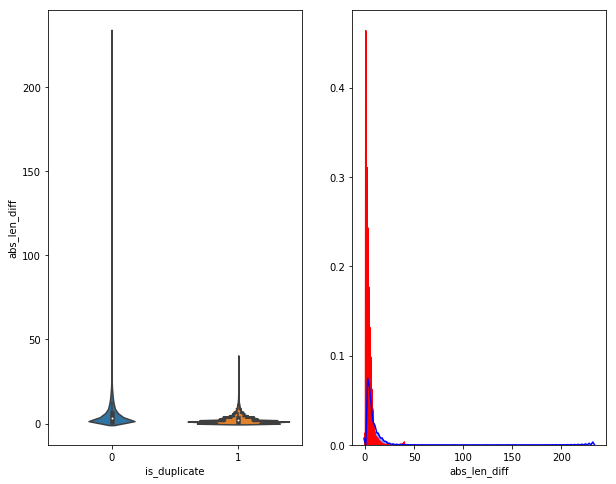





       MEAN_LEN     10


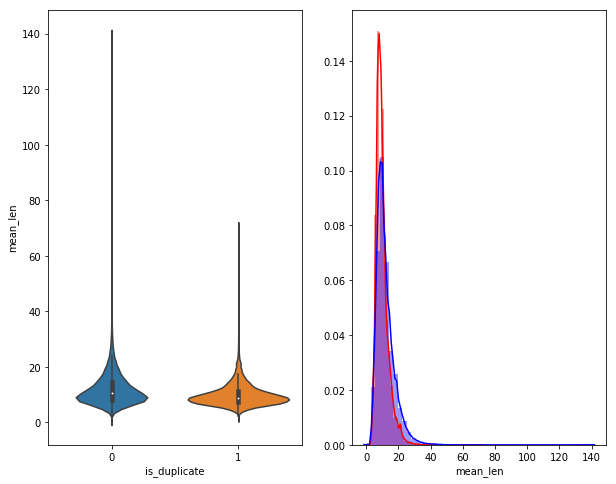





       TOKEN_SET_RATIO     11


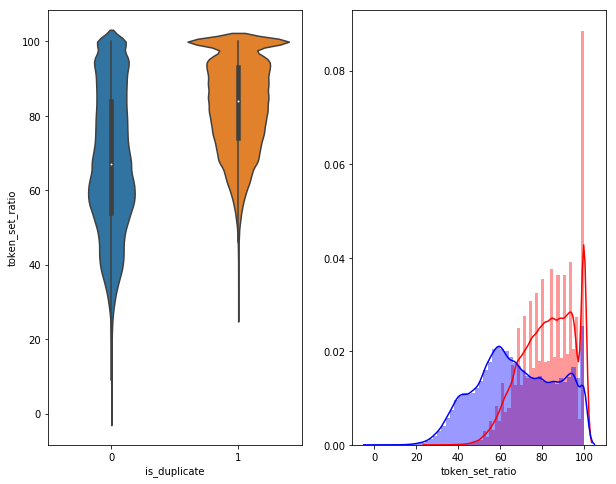





       TOKEN_SORT_RATIO     12


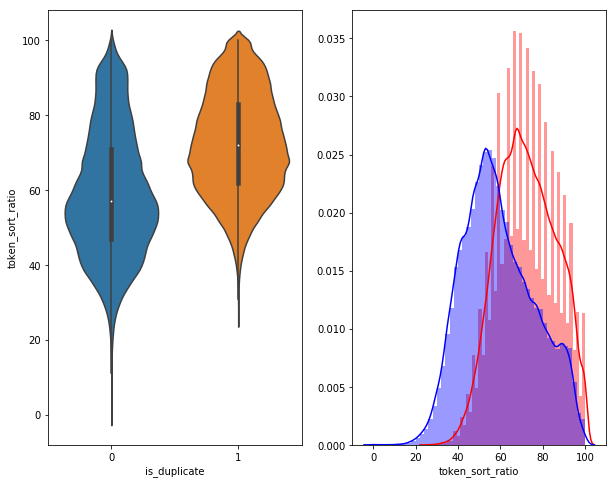





       FUZZ_RATIO     13


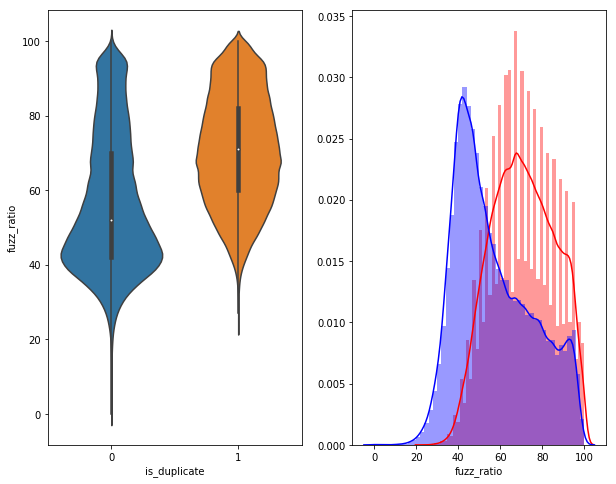





       FUZZ_PARTIAL_RATIO     14


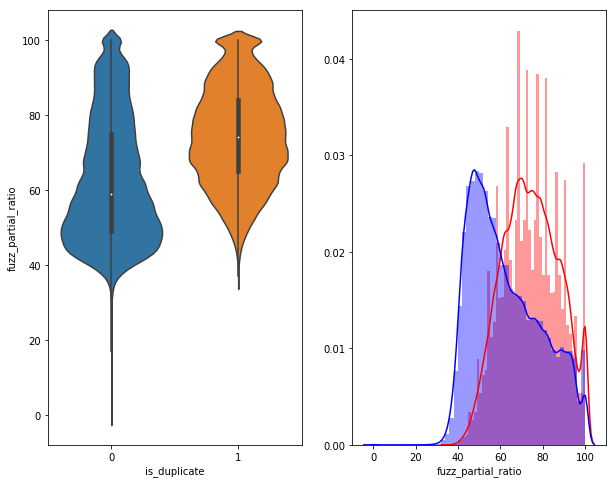





       LONGEST_SUBSTR_RATIO     15


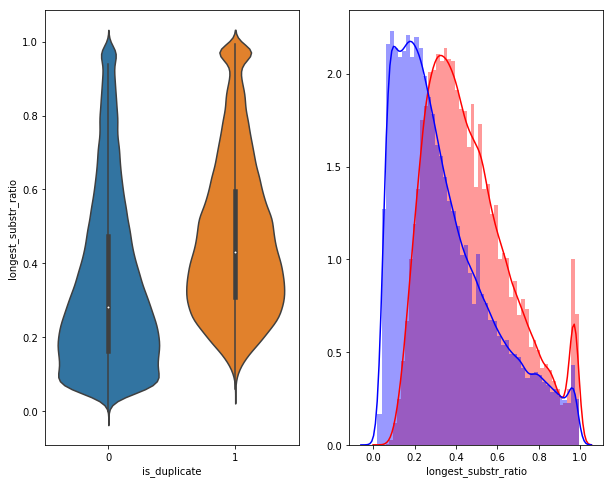

In [47]:
#creating a loop for plotting all features
data=df.iloc[:,5:]

for i in range(1,data.shape[1]):
    nm=data.iloc[:,i].name
    print('\n\n\n\n       {}     {}'.format(nm.upper(),i))
    plt.figure(figsize=(10, 8))
    plt.subplot(1,2,1)
    sns.violinplot(x = 'is_duplicate', y=nm , data = data[0:] , )

    plt.subplot(1,2,2)
    sns.distplot(data[data['is_duplicate'] == 1.0][nm][0:] , label = "1", color = 'red')
    sns.distplot(data[data['is_duplicate'] == 0.0][nm][0:] , label = "0" , color = 'blue' )
    plt.show()
    


Using tsne

In [60]:
dfscaled=data.iloc[:7000,1:]
x=MinMaxScaler().fit_transform(X=dfscaled.values)
y=data.iloc[:7000,0].values

In [65]:
tsne=TSNE(random_state=141,verbose=2).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.019s...
[t-SNE] Computed neighbors for 7000 samples in 0.512s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.105578
[t-SNE] Computed conditional probabilities in 0.299s
[t-SNE] Iteration 50: error = 86.5155258, gradient norm = 0.0345915 (50 iterations in 3.792s)
[t-SNE] Iteration 100: error = 73.7385635, gradient norm = 0.0061267 (50 iterations in 2.479s)
[t-SNE] Iteration 150: error = 71.3737259, gradient norm = 0.0038703 (50 iterations in 2.756s)
[t-SNE] Iteration 200: error = 

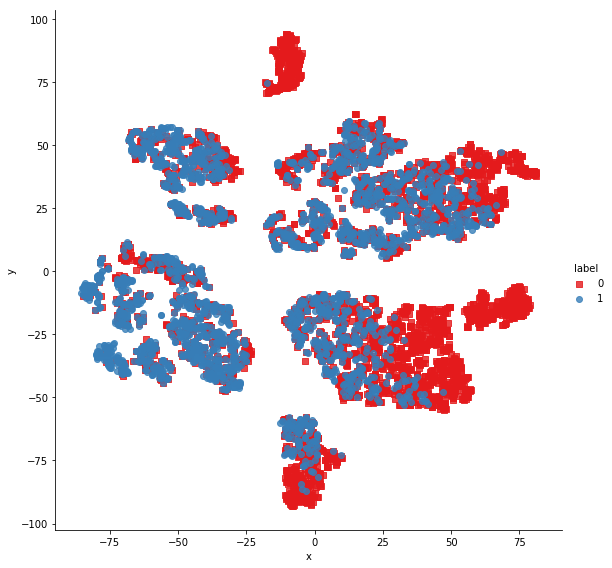

In [74]:
#plotting tsne
plott=pd.DataFrame({'x':tsne[:,0],'y':tsne[:,1],'label':y})
sns.lmplot(data=plott, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.show()


tsne shows that are selected features work well as we can separate labels at major areas using these 15 features